In [32]:
# libraries
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import math
from scipy.stats import multivariate_normal as mvn

In [33]:
df = pd.read_csv('data_proj_414.csv',index_col=0)
print(df)

               X          Y  Potter  Weasley  Granger  Trip  Close  Far
1       2.466284   3.582118       1        0        0     1      0    0
2       5.508336   8.295713       1        0        0     1      0    0
3       6.784481  11.851393       1        0        0     1      0    0
4       7.550499  14.411812       1        0        0     1      0    0
5      10.402096  17.218079       1        0        0     1      0    7
...          ...        ...     ...      ...      ...   ...    ...  ...
24090  40.615083  74.485727       0        0        1    49      4   16
24091  41.485127  74.335721       0        0        1    49      1    8
24092  41.275887  76.995216       0        0        1    49      1    2
24093  42.176981  76.159014       0        0        1    49      0    1
24094  40.530502  76.063805       0        0        1    49      1    8

[24094 rows x 8 columns]


Obtain a map[107][107] from the dataframe, use "Close" data first and then make up the untouched grids using "Far" data. 

In [34]:
def estimate_from_far(map_far, map_close, x, y, means, covs, r_factor): 
  #means = (0,0)
  #covs = [[1, 0], [0, 1]]
  acc = 0
  count = 0
  pdf = []
  for i in range(-2*r_factor, 3*r_factor):
    for j in range(-2*r_factor, 3*r_factor): 
      if (i, j) == (0, 0): 
        continue
      if (x+i) < 0 or (x+i) >= 107: 
        continue
      if (y+j) < 0 or (y+j) >= 107: 
        continue
      if (map_far[x+i][y+j] != -1): 
        
        i1 = i
        j1 = j
        if (i > 0): 
          i1 = i-r_factor
        elif (i < 0): 
          i1 = i+r_factor
        if (j > 0): 
          j1 = j-r_factor
        elif (j < 0): 
          j1 = j+r_factor
        temp1 = mvn.cdf((i/r_factor, j/r_factor), mean = means, cov = covs)
        temp2 = mvn.cdf((i1/r_factor, j1/r_factor), mean = means, cov = covs)#near the center
        if(temp2 > temp1): 
          acc = acc + (temp2-temp1) * (map_far[x+i][y+j] - map_close[x+i][y+j])
        else: 
          acc = acc + (temp1-temp2) * (map_far[x+i][y+j] - map_close[x+i][y+j])
        count = count + 1
  if count == 0: 
    val = 0
  else: 
    val = acc/count
  #print("acc, count, val: ", (acc, count, val))
  return(val)

In [35]:
resolution_factor=1
min_resolution_x=[]
min_resolution_y=[]


map_close = np.zeros((107*resolution_factor, 107*resolution_factor))
one_grid_count_close=np.zeros((107*resolution_factor, 107*resolution_factor))
max_one_grid_count_close=0

map_far = np.zeros((107*resolution_factor, 107*resolution_factor))
one_grid_count_far=np.zeros((107*resolution_factor, 107*resolution_factor))
max_one_grid_count_far=0

map_uneven = np.zeros((107*resolution_factor, 107*resolution_factor))
map_modified = np.zeros((107*resolution_factor, 107*resolution_factor))

for i in range(1, len(df['X'])+ 1):
  #if i<len(df['X']):
    #min_resolution_x.append(abs(df['X'][i]- df['X'][i+1])) #min(min_resolution_x,abs(df['X'][i]- df['X'][i+1]))
    #min_resolution_y.append(abs(df['Y'][i]- df['Y'][i+1]))#min(min_resolution_y,abs(df['Y'][i]- df['Y'][i+1]))
  x =int(round(df['X'][i],1 )*resolution_factor)
  y =int(round(df['Y'][i],1 )*resolution_factor)
  #record close
  one_grid_count_close[x][y]+=1
  max_one_grid_count_close=max(max_one_grid_count_close,one_grid_count_close[x][y])
  map_close[x][y] = map_close[x][y] + df['Close'][i]
  #record far
  one_grid_count_far[x][y] +=1
  max_one_grid_count_far=max(max_one_grid_count_far,one_grid_count_far[x][y])
  map_far[x][y] = map_far[x][y] + df['Far'][i]

#calculate close
for i in range(107*resolution_factor): 
  for j in range(107*resolution_factor): 
    if (one_grid_count_close[i][j] == 0): 
      map_close[i][j] = -1
    else: 
      map_close[i][j] = map_close[i][j] / one_grid_count_close[i][j]

#calculate far
for i in range(107*resolution_factor): 
  for j in range(107*resolution_factor): 
    if (one_grid_count_far[i][j] == 0): 
      map_far[i][j] = -1
    else: 
      map_far[i][j] = map_far[i][j] / one_grid_count_far[i][j]


#obtain the final map with estimation using far data
means = (0,0)
covs = [[1, 0], [0, 1]]

for i in range(107*resolution_factor): 
  for j in range(107*resolution_factor): 
    if (one_grid_count_close[i][j] == 0): 
      map_uneven[i][j] = estimate_from_far(map_far, map_close, i, j, means, covs, resolution_factor)
      if (map_uneven[i][j] != 0): 
        map_modified[i][j] = map_uneven[i][j] # a record of modified data using far data
    else: 
      map_uneven[i][j] = map_close[i][j]
      


/usr/local/lib/python3.7/dist-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


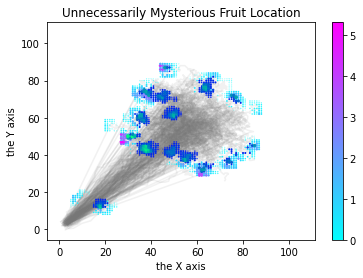

In [37]:
ntrip = 49

cmap = plt.cm.get_cmap('Greys')
for i in range(1, ntrip+1): 
    rs_df = df.loc[df['Trip'] == i]
    c = cmap(30/ntrip)
    plt.plot(rs_df['X'], rs_df['Y'], color = c, alpha = 0.1, zorder = 0)

X = []
Y = []
close = []
modi = []

for i in range(0,107*resolution_factor):
  for j in range(0,107*resolution_factor):
    X.append(i)
    Y.append(j)
    close.append(map_close[i][j])
    modi.append(map_modified[i][j])

plt.scatter(X, Y, s = close, c = close, cmap="winter", alpha=1, linewidth=1, zorder = 10)
plt.scatter(X, Y, s = modi, c = modi, cmap = "cool", alpha = 1, zorder = 5)
plt.xlabel("the X axis")
plt.ylabel("the Y axis")
plt.colorbar()
plt.title("Unnecessarily Mysterious Fruit Location")
plt.show()

In [38]:
def balance_out_map(map, x, y, r_factor): 
  left = 0
  right = 0
  up = 0
  down = 0
  if x > 0 and x < 106*r_factor: 
    if map[x-1][y] + map[x+1][y] != 0: 
      left = (map[x-1][y])/(map[x-1][y] + map[x+1][y])
      right = (map[x+1][y])/(map[x-1][y] + map[x+1][y])
    else: #nothing on the sides
      left = 0
      right = 0
  elif x > 0: # x = 106, rightmost column
    left = 1
    right = 0
  else: # x = 0, leftmost comlumn
    left = 0
    right = 1
  if y > 0 and y < 106*r_factor: 
    if map[x][y-1] + map[x][y+1] != 0: 
      down = (map[x][y-1])/(map[x][y-1] + map[x][y+1])
      up = (map[x][y+1])/(map[x][y-1] + map[x][y+1])
    else: # nothing
      up = 0
      down = 0
  elif y > 0: # y = 106, bottom row
    up = 1
    down = 0
  else: # y = 0, top row
    up = 0
    down = 1
  return({"left": left, "right": right, "up": up, "down": down})

In [39]:
map_proportion = [[{"left":0,"right":0, "up": 0, "down": 0} for y in range(107*resolution_factor)] for x in range(107*resolution_factor)]
for i in range(107*resolution_factor):
  for j in range(107*resolution_factor):
    map_proportion[i][j]= balance_out_map(map_uneven, i, j, resolution_factor)


In [59]:
def calculate_map(map_uneven, map_prop, x, y, r_factor): 
  count = 1
  acc = []
  acc.append(map_uneven[x][y] * map_prop[x][y]['left']*map_prop[x][y]['up'])
  if x > 0: 
    acc.append(map_uneven[x-1][y]*map_prop[x-1][y]['left']*map_prop[x-1][y]['down'])
    count = count + 1
  if y > 0: 
    acc.append(map_uneven[x][y-1]*map_prop[x][y-1]['right']*map_prop[x][y-1]['up'])
    count = count + 1
  if x > 0 and y > 0: 
    acc.append(map_uneven[x-1][y-1]*map_prop[x-1][y-1]['right']*map_prop[x-1][y-1]['down'])
    count = count + 1
  val = max(acc)
  return val
  

In [60]:
map_even = np.zeros((107*resolution_factor, 107*resolution_factor))
count = 0 
for i in range(107*resolution_factor):
  for j in range(107*resolution_factor):
    map_even[i][j] = calculate_map(map_uneven, map_proportion, i, j, resolution_factor)

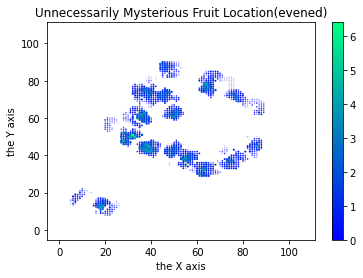

In [61]:
even = []

for i in range(0,107*resolution_factor):
  for j in range(0,107*resolution_factor):
    even.append(map_even[i][j])

plt.scatter(X, Y, s = even, c = even, cmap="winter", alpha=1, linewidth=1, zorder = 10)
# Add titles (main and on axis)
plt.xlabel("the X axis")
plt.ylabel("the Y axis")
plt.colorbar()

plt.title("Unnecessarily Mysterious Fruit Location(evened)")

# Show the graph
plt.show()

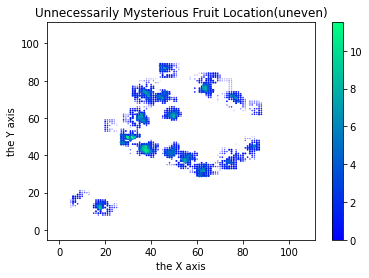

In [62]:
uneven = []
for i in range(0,107*resolution_factor):
  for j in range(0,107*resolution_factor):
    uneven.append(map_uneven[i][j])

plt.scatter(X, Y, s = uneven, c = uneven, cmap="winter", alpha=1, linewidth=1, zorder = 10)
# Add titles (main and on axis)
plt.xlabel("the X axis")
plt.ylabel("the Y axis")
plt.colorbar()

plt.title("Unnecessarily Mysterious Fruit Location(uneven)")

# Show the graph
plt.show()

In [63]:
np.histogram(even, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])


(array([11101,   210,    94,    34,     8,     1,     1,     0,     0,
            0,     0,     0]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]))

In [64]:
np.histogram(uneven, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

(array([10935,   248,   101,    58,    41,    22,    14,    17,     5,
            5,     1,     2]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]))